# Plasticity
[![Google Collab Book](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/meyer-nils/torch-fem/blob/main/examples/basic/planar/plasticity.ipynb)

We subject a 3D unit cube meshed with linear hexahedrons to a uniaxial stress state in the x-direction. The displacement is increased in increments and the material yields when the stress reaches a critical value. The material is modeled with a v. Mises yield criterion and a linear isotropic hardening law.


In [2]:
import matplotlib.pyplot as plt
import pickle as pkl
import numpy as np

import torch

from torchfem import Solid
from torchfem.materials import IsotropicPlasticity3D
from torchfem.mesh import cube_hexa, rect_quad

from torchfem.elements import linear_to_quadratic

torch.set_default_dtype(torch.float64)

## Material model
We employ a von Mises yield criterion with isotropic linear hardening. The plastic hardening function is given by

$$
\sigma_f(q) = \sigma_y + k q
$$

with the yield stress $\sigma_y$, the equivalent plastic strain $q$ and the hardening modulus $k$.

## Incremental loading with radial return mapping algorithm 
We implement a radial return mapping algorithm to solve the plasticity problem. In each increment, we calculate the trial stress 
$$ 
\sigma_{\text{trial}} = \sigma_n + C : \Delta\varepsilon
$$
and check if it exceeds the yield surface by evaluating the flow potential
$$ 
f = ||\sigma_{\text{trial}}'|| - \sqrt{\frac{2}{3}}\sigma_f(q).
$$
Here, $||\sigma_{\text{trial}}'||$ denotes the Frobenius norm of the deviatoric part of the trial stress.

1. If $f \leq 0$, the stress state is elastic. We update the variables as follows: 
$$
\sigma_{n+1} = \sigma_{\text{trial}} \\ q_{n+1} = q_{n}\\ d\sigma d\varepsilon_{n+1} = C.
$$

2. If $f > 0$, the stress state is plastic. We need to calculate the equivalent plastic strain $\Delta \gamma$ that leads to $f=0$ to satisfy the yield condition. This is generally a nonlinear equation and we solve it with Newton's method (in case of linear hardening, this is essentially solved in the first step...). We assume, that the direction of of flow is given by the deviatoric part of the trial stress, i.e. $n = \frac{\sigma_{\text{trial}}'}{||\sigma_{\text{trial}}'||}$.
Then, we update the variables as follows: 

$$
\sigma_{n+1} = \sigma_{\text{trial}} - 2 G \Delta \gamma n \\
\quad q_{n+1} = q_{n} + \sqrt{\frac{2}{3}} \Delta \gamma \\
(d\sigma d\varepsilon)_{ijkl} = C_{ijkl} 
    - \frac{2 G}{1 + \frac{\sigma_f'}{3 \mu}} n_{ij} n_{kl}
    - \frac{4 G^2 \Delta\gamma}{||s||} \left(\frac{1}{2} \left( \delta_{ik}\delta_{jl} + \delta_{il}\delta_{kj} \right)
         - \frac{1}{3} \delta_{ij} \delta_{kl}
        - n_{ij} n_{kl} \right)
$$

In [2]:
E = 100000.0
nu = 0.3
sigma_y = 50.0
k = 100.0


# # Hardening function
# def sigma_f(q):
#     return sigma_y + k * q


# # Derivative of the hardening function
# def sigma_f_prime(q):
#     return k

# Plasticity parameters for new formulation
# y_0 - initial yield stress
y_0 = 10
# y_00 - final yield stress
y_inf = 250
# omega - saturation parameter
omega = 100

# Plastic formulation
# plastic potential
# ψ̂_p(α) = (y_∞ - y_0)(-1/ω + α + (1/ω)exp(-ωα))
# derivative of plastic potential
# β = ∂_α ψ̂_p(α) = (y_∞ - y_0)(1 - exp(-ωα))
# yield surface
# φ̂(σ, β) = ||σ'|| - √(2/3)(y_0 + β)
def psi_p(alpha):
    """Plastic potential function.""" 
    return (y_inf - y_0) * (-1/omega + alpha + (1/omega) * torch.exp(
        -omega * alpha)) 

def beta_function(alpha):
    """Beta function: β = ∂_α ψ̂_p(α)."""
    return (y_inf - y_0) * (1 - torch.exp(-omega * alpha))

def sigma_f(alpha):
    """Yield function: σ_f = √(2/3)(y_0 + β)."""
    beta = beta_function(alpha)
    return torch.sqrt(torch.tensor(2/3)) * (y_0 + beta)

def sigma_f_prime(alpha):
    """Derivative of yield function: dσ_f/dα.""" 
    # d/dα [√(2/3)(y_0 + β)] = √(2/3) * dβ/dα
    # dβ/dα = (y_∞ - y_0) * ω * exp(-ωα) 
    dbeta_dalpha = (y_inf - y_0) * omega * torch.exp(-omega * alpha)
    return torch.sqrt(torch.tensor(2/3)) * dbeta_dalpha               

# Elastic properties
material = IsotropicPlasticity3D(E, nu, sigma_f, sigma_f_prime)

In [3]:
dim = 3
material_behavior = 'elastoplastic'
# e_young = 110000
# nu = 0.33
# sigma_y = 50.0
# k = 100.0

element_type = 'hex20'
patch_idx = 0
num_increments = 1
# number of elements per direction
mesh_nx = 3
mesh_ny = 3
mesh_nz = 3
filepath = f'/Users/rbarreira/Desktop/machine_learning/' + \
            f'material_patches/2025_06_05/'

input_filename = filepath + \
        f'material_patches_generation_{dim}d_' + \
        f'{element_type}_mesh_{mesh_nx}x{mesh_ny}x{mesh_nz}/' + \
        f'material_patch_{patch_idx}/material_patch/' + \
        f'material_patch_attributes.pkl'

with open(input_filename, 'rb') as file:
    matpatch = pkl.load(file)

mesh_coords_ref = matpatch.get('mesh_nodes_coords_ref', {})

In [4]:
# Generate cube
nodes, elements = cube_hexa(mesh_nx + 1, mesh_ny + 1, mesh_nz + 1)
# nodes, elements = linear_to_quadratic(nodes, elements)
box = Solid(nodes, elements, material)

In [5]:
def apply_displacements_by_coordinates(domain, displacement_data, dim=3):
    """
    Apply displacements by matching mesh coordinates with reference coordinates
    """
    mesh_coords_ref = displacement_data.get('mesh_nodes_coords_ref', {})
    boundary_disps = displacement_data.get('mesh_boundary_nodes_disps', {})
    
    nodes = domain.nodes.numpy()
    tolerance = 1e-6
    
    applied_count = 0
    
    for node_str, ref_coord in mesh_coords_ref.items():
        if node_str in boundary_disps:
            ref_point = np.array(ref_coord)
            
            # Find matching node in the mesh
            distances = np.sqrt(np.sum((nodes - ref_point)**2, axis=1))
            closest_idx = np.argmin(distances)
            
            if distances[closest_idx] < tolerance:
                disp_data = boundary_disps[node_str]

                # print(f'disp data: {disp_data}')
                # print(f'disp data: {np.shape(disp_data)}')

                if dim == 2:
                    # Apply displacement for first time step
                    domain.displacements[closest_idx, 0] = float(
                        disp_data[0])
                    domain.displacements[closest_idx, 1] = float(
                        disp_data[1])
                    
                    # Set constraints
                    domain.constraints[closest_idx, 0] = True
                    domain.constraints[closest_idx, 1] = True
                    
                    applied_count += 1
                elif dim == 3:
                    # Apply displacement for first time step
                    domain.displacements[closest_idx, 0] = float(
                        disp_data[0])
                    domain.displacements[closest_idx, 1] = float(
                        disp_data[1])
                    domain.displacements[closest_idx, 2] = float(
                        disp_data[2])
                    
                    # Set constraints
                    domain.constraints[closest_idx, 0] = True
                    domain.constraints[closest_idx, 1] = True
                    domain.constraints[closest_idx, 2] = True
                    
                    applied_count += 1


    if applied_count == len(boundary_disps.keys()):
        print(f"Applied displacements to {applied_count} nodes.")
    else:
        raise RuntimeError("Wrong number of boundary displacements!")


# applied_count = apply_displacements_by_coordinates(box, matpatch)

In [6]:
# # Set constraints
DL = 0.05
box.displacements[nodes[:, 0] == 1.0, 0] = DL
box.constraints[nodes[:, 0] == 0.0, 0] = True
box.constraints[nodes[:, 0] == 1.0, 0] = True
box.constraints[nodes[:, 1] == 0.5, 1] = True
box.constraints[nodes[:, 2] == 0.5, 2] = True

# Incremental loading
# increments = torch.linspace(0.0, 1.0, 20)
increments = torch.cat((torch.linspace(0.0, 1.0, 20),
                        torch.linspace(1.0, 0.0, 20)))
u, f, σ, F, α, vol_elem = box.solve(
    increments=increments, return_intermediate=True,
    return_volumes=True,
    max_iter=1000, rtol=1e-6)

/Users/rbarreira/mambaforge/envs/env_torchfem/lib/python3.13/site-packages/torchfem/sparse.py:262: MatrixRankWarning: Matrix is exactly singular
  x_xp = scipy_spsolve(A_np, b_np)


In [7]:
# Plot the equivalent plastic strain alpha
# α has shape (num_increments, num_elements, num_integration_points)
# We'll use the final increment and average over integration points

# Get the final plastic strain (last increment)
alpha_final = α[-1, :, :].mean(dim=1)  # Average over integration points

# Plot using box.plot() with element_property (since alpha is per element)
# Use scalars to specify which property to visualize
box.plot(u[-1, :, :], element_property={'alpha': alpha_final}, 
         scalars='alpha', cmap='plasma', show_scalar_bar=True)

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

In [8]:
torch.linspace(1.0, 1.0, 1)

tensor([1.])

In [9]:

print(nodes)
print(u[1,:,:])
print(f[1,:,:])

tensor([[0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.3333],
        [0.0000, 0.0000, 0.6667],
        [0.0000, 0.0000, 1.0000],
        [0.0000, 0.3333, 0.0000],
        [0.0000, 0.3333, 0.3333],
        [0.0000, 0.3333, 0.6667],
        [0.0000, 0.3333, 1.0000],
        [0.0000, 0.6667, 0.0000],
        [0.0000, 0.6667, 0.3333],
        [0.0000, 0.6667, 0.6667],
        [0.0000, 0.6667, 1.0000],
        [0.0000, 1.0000, 0.0000],
        [0.0000, 1.0000, 0.3333],
        [0.0000, 1.0000, 0.6667],
        [0.0000, 1.0000, 1.0000],
        [0.3333, 0.0000, 0.0000],
        [0.3333, 0.0000, 0.3333],
        [0.3333, 0.0000, 0.6667],
        [0.3333, 0.0000, 1.0000],
        [0.3333, 0.3333, 0.0000],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.6667],
        [0.3333, 0.3333, 1.0000],
        [0.3333, 0.6667, 0.0000],
        [0.3333, 0.6667, 0.3333],
        [0.3333, 0.6667, 0.6667],
        [0.3333, 0.6667, 1.0000],
        [0.3333, 1.0000, 0.0000],
        [0.333

## Postprocessing and evaluation

The reference solution for the plastic region is given by solving the hardening rule
$$
\sigma = \sigma_y + K q
$$
for $q$ and substituting it into the elastic equation
$$
\sigma = E (\varepsilon - q).
$$
Solving for $\sigma$ gives 
$$
\sigma = \frac{kE}{k+E} (\varepsilon + \frac{\sigma_y}{k}).
$$

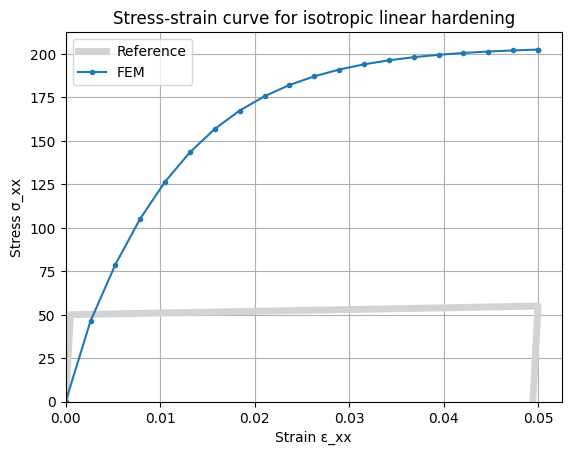

In [10]:
ref_strain = [0.0, sigma_y / E, DL, DL - k / (k + E) * (DL + sigma_y / k)]
ref_stress = [0.0, sigma_y, k * E / (k + E) * (DL + sigma_y / k), 0]

# Average x components over elements
ε = 0.5 * (F.transpose(-1, -2) + F) - torch.eye(3)
strain = ε[:, :, 0, 0].mean(dim=1)
stress = σ[:, :, 0, 0].mean(dim=1)

plt.plot(ref_strain, ref_stress, "-", color="lightgray", linewidth=5, label="Reference")
plt.plot(strain, stress, ".-", label="FEM")
plt.xlabel("Strain ε_xx")
plt.ylabel("Stress σ_xx")
plt.title("Stress-strain curve for isotropic linear hardening")
plt.ylim(bottom=0)
plt.xlim(left=0)
plt.grid()
plt.legend()
plt.show()

In [4]:
# Load the pickle file
filename = f'/Users/rbarreira/Desktop/machine_learning/material_patches/' + \
    f'_data/elastoplastic/2d/quad4/mesh1x1/ninc1/matpatch_idx0.pkl'


with open(filename, 'rb') as f:
    simulation_data = pkl.load(f)

# Check if interpolated_coords is empty
mesh_nodes_matrix = simulation_data['mesh_nodes_matrix']

print(mesh_nodes_matrix)


[[0 1]
 [2 3]]
